# **1D Map Conjugacy for the Lorenz System**

In [1]:
import numpy as np
from utils import Lorenz
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

## **Generate Measurement Data**

In [2]:
# Continuous-time simulation data

# Initializations
dt = .005
t_span = np.arange(0, 20000, dt)
rho = 28.0
x0 = [2, 0, rho-1]  

# Solution data
xsol = []
xsol = odeint(Lorenz, x0, t_span, args = (rho,))

Text(0, 0.5, '$x_3(t)$')

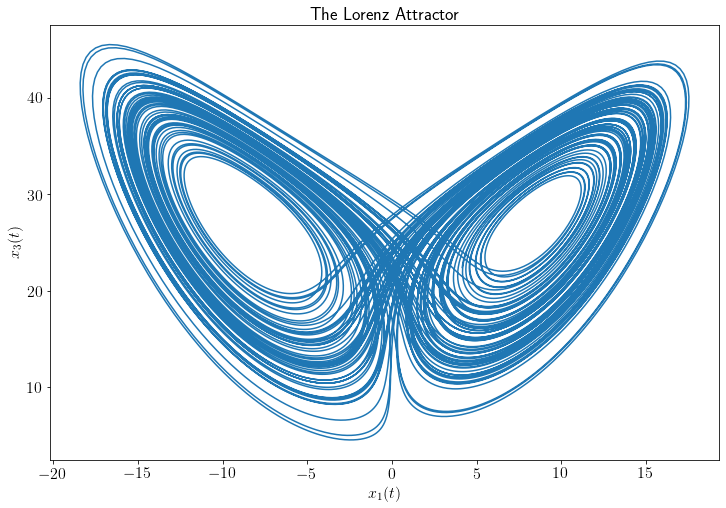

In [3]:
# Plot Lorenz Solution (x_3 vs. x_1)

plt.plot(xsol[1:20000,0],xsol[1:20000,2])
plt.title("The Lorenz Attractor")
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_3(t)$")

In [4]:
# Create section data

Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if xsol[m,2] >= (rho -1) and xsol[m+1,2] <= (rho -1): # section condition
        temp[count] = xsol[m+1,:-1] 
        count = count + 1
Psec.append(np.array(temp[1:count]))   

xn, xnp1 = Psec[0][:-1], Psec[0][1:]

#Scale data into [-1,1]
max_xn = xn.max()
min_xn = xn.min()

slope = 2/(max_xn - min_xn)
yint = -1-slope*min_xn

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

xnp1 = xnp1[:-forward_iters] 
for j in range(forward_iters): 
    xnforward.append(xn[j:-forward_iters+j])

Text(0, 0.5, '$x_2$')

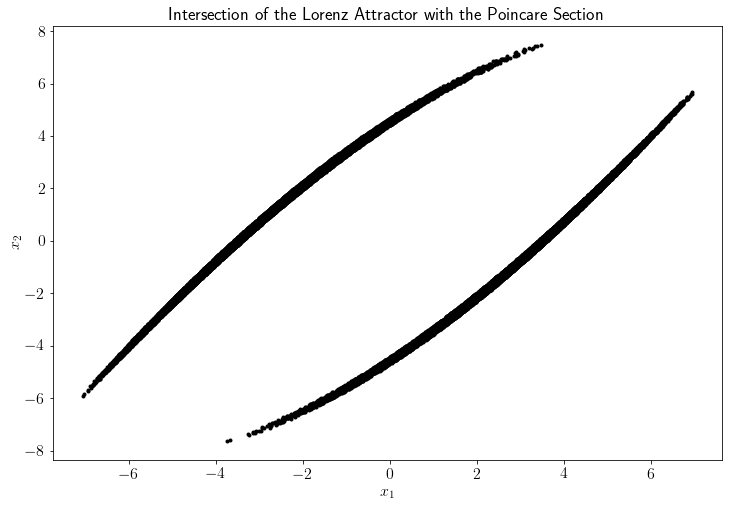

In [5]:
# Plot Lorenz Section Data

plt.plot(Psec[0][:,0],Psec[0][:,1],'k.')
plt.title("Intersection of the Lorenz Attractor with the Poincare Section")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

## **Network Architecture and Training**

In [7]:
# Build Neural Network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Conjugacy Network
class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 activation = 'selu', 
                 steps = 1,
                 numblks_in = 1,
                 numblks_out = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.activation = activation
    self.steps = steps
    self.numblks_in = numblks_in
    self.numblks_out = numblks_out
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)

    # Piecewise map variables
    self.c1 = tf.Variable(2.5248156, trainable = False) 
    self.c2 = tf.Variable(1.659471, trainable = False) 
    
    # Encoder function
    self.encoder = tf.keras.Sequential(name = 'encoder')
    
    for n in range(self.numblks_in): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.encoder.add(layers.Dense(1, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential(name = 'decoder')

    for n in range(self.numblks_out): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.decoder.add(tf.keras.layers.Dense(2, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x[0])
    
    # y mapping
    encoded_p1 = -tf.math.sign(encoded) + self.c1*encoded + self.c2*tf.math.multiply(tf.math.sign(encoded),tf.square(encoded))
    
    decoded = self.decoder(encoded_p1)

    # Conjugacy loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x[0] - x_recon)))
    
    # Build loss function
    yn = encoded
    for s in range(self.steps):
        ynp1 = self.encoder(x[s+1])
        
        # Iteration loss in y
        y_step = -tf.math.sign(yn) + self.c1*yn + self.c2*tf.math.multiply(tf.math.sign(yn),tf.square(yn))
        self.add_loss((tf.reduce_mean(tf.math.square(ynp1 - y_step)))/self.steps)
        
        # Iteration loss in x
        xnp1 = self.decoder(y_step)
        self.add_loss((tf.reduce_mean(tf.math.square(x[s+1] - xnp1)))/self.steps)
        
        yn = y_step
        
    return decoded

In [8]:
# Training the network

width = 100
activation = 'selu'
learning_rate = 0.0001
batch_size = 10
steps = 2
numblks_in = 3
numblks_out = 3

conjugacy = Conjugacy(width, activation, steps, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10) # patience is set intentially low to speed up examples

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse')

conjugacy.fit(xnforward, xnp1, callbacks = [callback], epochs = 1000)

Epoch 1/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.4814
Epoch 2/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.4023
Epoch 3/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3844
Epoch 4/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3675
Epoch 5/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3583
Epoch 6/1000
832/832 [==============================] - 2s 2ms/step - loss: 0.3496
Epoch 7/1000
832/832 [==============================] - 2s 2ms/step - loss: 0.3454
Epoch 8/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3402
Epoch 9/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3398
Epoch 10/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3369
Epoch 11/1000
832/832 [==============================] - 1s 2ms/step - loss: 0.3354
Epoch 12/1000
832/832 [==============================] - 2s 2ms/step - loss: 0.3326
E

## **Network Output**

In [10]:
# Print Discovered Mapping

print('Discovered Conjugate Mapping:')
print('')
print('g(y) = -sgn(y) +',conjugacy.c1.numpy(),'*y +',conjugacy.c2.numpy(),'*y*|y|')

# Network Summary
print('')
conjugacy.summary()

Discovered Conjugate Mapping:

g(y) = -sgn(y) + 2.5248156 *y + 1.659471 *y*|y|

Model: "conjugacy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 1)                 20601     
_________________________________________________________________
decoder (Sequential)         (None, 2)                 20602     
Total params: 41,205
Trainable params: 41,203
Non-trainable params: 2
_________________________________________________________________
